In [1]:
from datetime import datetime, time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sys, os
parent_dir = os.getcwd()
path = os.path.dirname(parent_dir)
sys.path.append(path)

In [3]:
path

'/home/ds6/w210'

In [7]:

class reward:
    
    
    def __init__(self):
        """
        Initialize the reward module. 
        
        args: 
        
        """
        #self.region = region
        #self.tariff_type = tariff_type
        #self.export_tariff = export_tariff
        
        self.TOU = {
            "VIC":{"peak": 0.3021, "shoulder": 0.1735, "off-peak": 0.1735, 'solar':0.052, 'connection': 1.1623},
            "NSW":{"peak": 0.6234, "shoulder": 0.2839, "off-peak": 0.1642, 'solar':0.050, 'connection': 1.0480},
            "QLD":{"peak": 0.3566, "shoulder": 0.2500, "off-peak": 0.2032, 'solar':0.050, 'connection': 1.2180},
            "SA":{"peak": 0.4435, "shoulder": 0.2178, "off-peak": 0.2633, 'solar':0.050, 'connection': 0.9514}
        }
        
    def get_tariff_rate(self, current_timestamp, region):
        """
        Returns the Tariff Rate for a given region and timestamp, based on the ToU dict.
        
        inputs:
            current_timestamp (datetime.datetime): The time stamp including date and time. 
            region (str)
            
        return (float): The rate in $/kWh
        
        """
    
        current_time = current_timestamp.time()
        
        if region == 'VIC':
            # Only peak or shoulder/off-peak
            if self.time_between(time(15,0), time(21,0), current_time):
                return self.TOU['VIC']['peak']
            else: #shoulder/off-peak - either doesn't matter.
                return self.TOU['VIC']['shoulder']
            
        elif region == 'SA':
            # Determine whether peak, shoulder or off-peak
            if self.time_between(time(6,0), time(10,0), current_time) or self.time_between(time(15,0), time(1,0), current_time):                
                return self.TOU['SA']['peak']
            elif self.time_between(time(1,0), time(6,0), current_time):
                return self.TOU['SA']['off-peak']
            else: #shoulder
                return self.TOU['SA']['shoulder']
        
        else:
            # Either NSW or QLD which have weekday dependent peaks
            dow = current_timestamp.weekday()
            if region == 'QLD':
                if self.time_between(time(22,0), time(7,0), current_time):
                    return self.TOU['QLD']['off-peak']
                elif dow < 5 and self.time_between(time(16,0), time(20,0), current_time):
                    return self.TOU['QLD']['peak']
                else:
                    return self.TOU['QLD']['shoulder']
            
            elif region == 'NSW':
                # NSW only has a peak in winter and autum
                month = current_timestamp.month
                if self.time_between(time(22,0), time(7,0), current_time):
                    return self.TOU['NSW']['off-peak']
                # If it's a weekday, in peak time during the months of Summer or Winter. 
                elif dow < 5 and self.time_between(time(14,0), time(20,0), current_time) and month in [1,2,3,6,7,8,12]:
                    return self.TOU['NSW']['peak']
                else:
                    return self.TOU['NSW']['shoulder']             
            else:
                print('unknown region!')
                
            
    def get_solar_fit(self, region):
        """
        Returns the rate of reward for solar power exported in $/kWh by region
        region (str): The state as string
        """
        return self.TOU[f'{region}']['solar']
    
    def get_connection_fee(self, region):
        """
        Returns the daily connection fee in $/day
        region (str): The state as string
        
        """
        return self.TOU[f'{region}']['connection']         

    def time_between(self, begin_time, end_time, check_time):
        """
        Checks if a time is between two times. 
        from https://stackoverflow.com/questions/10048249/how-do-i-determine-if-current-time-is-within-a-specified-range-using-pythons-da

        """

        check_time = check_time
        if begin_time < end_time:
            return check_time >= begin_time and check_time <= end_time
        else: # crosses midnight
            return check_time >= begin_time or check_time <= end_time

def get_month(dt):
    
    m_sin = np.sin(2 * np.pi * dt.month / 12)
    m_cos = np.cos(2 * np.pi * dt.month / 12)

    return m_cos, m_sin

def polar_time(dt, interval=5):
    """
    Takes a timestamp as input and returns the time in time
    """

    current_m = dt.minute
    # Get utc offset in seconds
    utc_offset = dt.utcoffset()
    if utc_offset == 10.5 * 60 * 60 or utc_offset == 11 * 60 * 60:
        if dt.hour == 0:
            current_hour = 23
        else:
            current_h = dt.hour - 1
    else:
        current_h = dt.hour

    n_intervals = 24 * 60 / interval

    g_min = int((current_h * 60 / interval) + (current_m // interval))
    t_sin = np.sin(2 * np.pi * g_min / n_intervals)
    t_cos = np.cos(2 * np.pi * g_min / n_intervals)
    
    return t_cos, t_sin

def encode_region(region):

    if region == 'NSW':
        return [0,0,0]
    elif region == 'VIC':
        return [1,0,0]
    elif region == 'QLD':
        return [0,1,0]
    elif region == 'SA':
        return [0,0,1]
    else:
        raise Exception(f'Region {region} not recognised!')


In [8]:
def calculate_grid_load(solar, home, max_discharge, max_charge, scenario):
    """
    Function to return the action for the battery based off some strongly defined programming
    logic.
    args:
     solar - solar output at that time. Float, negative.
     home - household loads at that time Float, positive.
     max_discharge - discharge potential float, negative. ### Note the current code assumes positive.
     max_charge - charge potential of the battery float, positive.
     senario - string, describes which scenario is being modelled.
    
    """
    
    # Here the sign counts - make solar negative. 
    if solar > 0:
        solar = solar * -1
        
    net = home + solar
    
    if scenario == 'StatusQuo':
        """
        Battery cannot export or import energy.
        Must charge from solar and take max possible,
        Must meet loads to fullest extent.
        """
        
        # Surplus Load - we need to either import and/or discharge  
        if net > 0:
            state = 'discharge'
            if abs(max_discharge) >= net: # Deficit met by battery
                bat_output = - net
                grid = 0
            elif abs(max_discharge) < net: # Deficit not fully met by battery, need to import
                bat_output = max_discharge
                grid = net + bat_output

        # Surplus Solar - we need to either export, and/or charge
        elif net < 0:
            state = 'charge'
            if max_charge > abs(net): # Soak up all the excess solar, no export
                bat_output = - net
                grid = 0
            elif max_charge <= abs(net): # Soak up as much as we can, export the rest of the solar.
                bat_output = max_charge
                grid = net + bat_output

        else: # No load or solar, net = 0
            bat_output = 0
            grid=0
            state = 'standby'
    
    return grid, state, bat_output

In [9]:
# Load data and metadata
raw_df =pd.read_parquet('data/simple_pricing/compiled_data_simpleprice.parquet')
#metadata = pd.read_csv('device_metadata.csv')

In [10]:
df_list = []
device_list = raw_df.DeviceID.unique().tolist()

In [11]:
device_list.remove('DDE4108627874')
print(len(device_list))

ValueError: list.remove(x): x not in list

# PLot a single Device

In [12]:
demo_device = device_list[0]
device_data = raw_df[raw_df['DeviceID'] == demo_device].copy()

In [13]:
# PLot summer and Winter

In [14]:
def season(month):
    if month in [1,2,11,12]:
        return 'summer'
    elif month in [5,6,7,8]:
        return 'winter'
    elif month in [9,10]:
        return 'spring'
    else:
        return 'fall'    

In [15]:
#device_data.[:,"month"]
device_data.loc[:,"month"] = device_data.Datetime.apply(lambda x: x.month)
device_data.loc[:,"hour"] = device_data.Datetime.apply(lambda x: x.hour)
device_data.loc[:,"season"] = device_data.Datetime.apply(lambda x: season(x.month))

In [16]:
aggregated_df = device_data.groupby(['season', 'hour']).agg(
    {
        "Solar Consumption": ['mean', 'std'],
        "Home Consumption": ['mean', 'std']
    }
    ).reset_index()
aggregated_df

season hour Solar Consumption               Home Consumption          
                             mean           std             mean       std
0     fall    0      0.000000e+00  0.000000e+00         0.021982  0.007322
1     fall    1      0.000000e+00  0.000000e+00         0.021931  0.007545
2     fall    2      0.000000e+00  0.000000e+00         0.021187  0.007428
3     fall    3      0.000000e+00  0.000000e+00         0.020890  0.007447
4     fall    4      0.000000e+00  0.000000e+00         0.021312  0.007651
..     ...  ...               ...           ...              ...       ...
91  winter   19      0.000000e+00  0.000000e+00         0.055102  0.028128
92  winter   20      1.016260e-08  4.114982e-07         0.045196  0.023960
93  winter   21      0.000000e+00  0.000000e+00         0.036787  0.019053
94  winter   22      0.000000e+00  0.000000e+00         0.035490  0.018037
95  winter   23      0.000000e+00  0.000000e+00         0.024697  0.008955

[96 rows x 6 columns]

In [44]:
aggregated_df.columns

MultiIndex([(           'season',     ''),
            (             'hour',     ''),
            ('Solar Consumption', 'mean'),
            ('Solar Consumption',  'std'),
            ( 'Home Consumption', 'mean'),
            ( 'Home Consumption',  'std')],
           )

<ErrorbarContainer object of 3 artists>

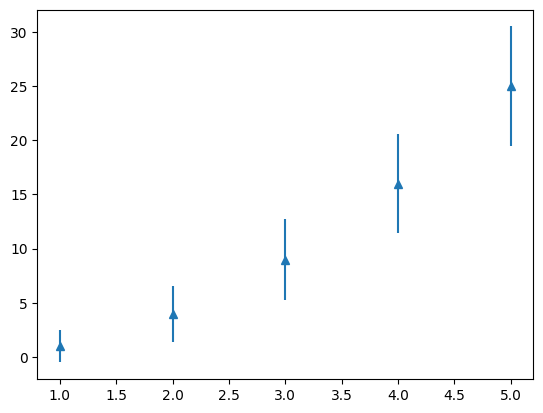

In [43]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array([1, 2, 3, 4, 5])
y = np.power(x, 2) # Effectively y = x**2
e = np.array([1.5, 2.6, 3.7, 4.6, 5.5])

plt.errorbar(x, y, e, linestyle='None', marker='^')


In [ ]:
fig, axs = plt.subplot(2,2)

axs[0] = plt.errorbar(x, y, e, linestyle='None', marker='^')

In [17]:
from models.battery_simulator import battery

In [18]:
def current_bill(solar, loads, in_t, out_t):
    net = solar + loads
    if net > 0:
        return abs(net * out_t)
    else:
        return abs(net * in_t) * -1

In [19]:
raw_df.loc[:,'loads'] =  abs(raw_df['Home Consumption'])
raw_df.loc[:,'import_tariff'] =  abs(raw_df['import_tariff']) * -1
raw_df.loc[:,'net'] = raw_df['solar'] + raw_df['loads']

In [20]:
#raw_df.loc[:,"current_bill"] = 
raw_df.loc[:,"current_bill"] = raw_df.apply(lambda x: current_bill(x.solar, x.loads, x.import_tariff, x.export_tariff), axis=1)

In [21]:
device_list[0:10]

['DD04108401266',
 'DD04108624381',
 'DD04108624683',
 'DD04108625556',
 'DD04108627065',
 'DD04108627645',
 'DD04108746744',
 'DD04108747038',
 'DD14108624198',
 'DD14108624638']

Looped implementation

In [22]:
## Create some new columns to collect actions
result_list = []
complete_df = raw_df
#debug
verbose = False
num_devices_to_try = 5
num_devices = 1

for device in device_list:     
    
    
    # Create a new dataframe for that device
    device_data = complete_df[complete_df['DeviceID'] == device].copy()
    
    # Make sure that the measurements are in order. 
    device_data.sort_values('Timestamp', inplace=True)
    current_ = sum(device_data.current_bill)
    capacities = [2,4,6,8,10,12,14,16,18,20]
    n_days = len(device_data)
    bat_dict = {
        'device': [device for _ in range(len(capacities))],
        'bat_capacity':capacities,
        'current_cost':[current_ for _ in range(len(capacities))],
        'battery_cost':[],
        'average_daily_cost':[],
        'n_days':[n_days for _ in range(len(capacities))]
    }

    for c in capacities:
                
        reward = 0
        reward_total = 0
        
        bat = None
        for m in device_data.index:

            # Get Solar, and Load, caculate the net energy
            sol = device_data.loc[m]['solar']
            hom = device_data.loc[m]['Home Consumption']
            ToU = device_data.loc[m]['import_tariff']
            sToU = device_data.loc[m]['export_tariff']
            
            net = hom + sol 

            # Instantiate Battery the first time - DOUBLE CHECK CLASSES!
            if bat == None:
                ###bat = battery_simulator.battery(capacity=14, exportable=False, importable=False) ###Redo when we 
                bat = battery(capacity=c, exportable=False, importable=False)
                bat.avl_energy = c # kWh
                if verbose:
                    print(f'Battery Initialised: Available Energy {bat.avl_energy} kWh')

            # Get discharge/charge limits from the battery:
            a_d, a_c = bat.get_limits(sol, hom)
            
            # Update Resolve Action
            grid, state, bat_out = calculate_grid_load(sol, hom, a_d, a_c, 'StatusQuo' )

            # Update State
            if state == 'charge':
                bat.charge(abs(bat_out))
                reward = abs(grid * sToU )
            elif state == 'discharge':
                bat.discharge(bat_out)
                reward = abs(grid * ToU) * -1
            else:
                reward = 0 ### why would it ever be zero?
            reward_total += reward

        bat_dict['battery_cost'].append(reward_total)  
        bat_dict['average_daily_cost'].append(reward_total/n_days)
        print(f'Revised bill: ${reward_total:.2f} for device: {device} with capacty:{c} kw') ### Need to add this to final chart later
    result_list.append(pd.DataFrame(bat_dict))
result_df = pd.concat(result_list)
result_df.to_csv('backup.csv')

Revised bill: $-81.47 for device: DD04108401266 with capacty:2 kw
Revised bill: $63.31 for device: DD04108401266 with capacty:4 kw
Revised bill: $135.31 for device: DD04108401266 with capacty:6 kw
Revised bill: $168.16 for device: DD04108401266 with capacty:8 kw
Revised bill: $182.69 for device: DD04108401266 with capacty:10 kw
Revised bill: $191.50 for device: DD04108401266 with capacty:12 kw
Revised bill: $197.89 for device: DD04108401266 with capacty:14 kw
Revised bill: $202.38 for device: DD04108401266 with capacty:16 kw
Revised bill: $205.89 for device: DD04108401266 with capacty:18 kw
Revised bill: $208.60 for device: DD04108401266 with capacty:20 kw
Revised bill: $-259.34 for device: DD04108624381 with capacty:2 kw
Revised bill: $-121.71 for device: DD04108624381 with capacty:4 kw
Revised bill: $-34.44 for device: DD04108624381 with capacty:6 kw
Revised bill: $17.23 for device: DD04108624381 with capacty:8 kw
Revised bill: $50.73 for device: DD04108624381 with capacty:10 kw
Revi

In [99]:
d1_len = len(complete_df[complete_df['DeviceID'] == device_list[0]])
d2_len = len(complete_df[complete_df['DeviceID'] == device_list[1]])
x1 = result_list[0].bat_capacity
y1 = result_list[0].battery_cost * -1
y2 = result_list[1].battery_cost * -1
y11 = result_list[0].battery_cost * -1 / (d1_len / 12 / 24) * 100
y22 = result_list[1].battery_cost * -1 / (d2_len / 12 / 24) * 100
d1 = result_list[0].device
d2 = result_list[1].device
print(f"{d1_len/ 12 / 24} {d2_len / 12 / 24}")

531.8784722222223 385.0


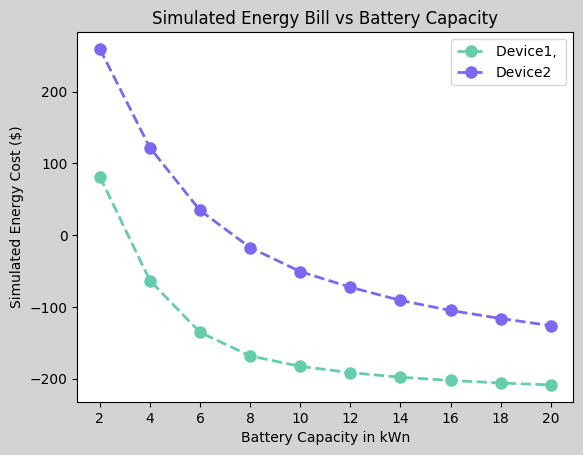

In [104]:
plt.figure(facecolor='lightgrey')
plt.plot(x1, y1, color='mediumaquamarine', marker='o', linestyle='dashed',linewidth=2, markersize=8)
plt.plot(x1, y2, color='mediumslateblue', marker='o', linestyle='dashed',linewidth=2, markersize=8)
plt.title('Simulated Energy Bill vs Battery Capacity')
plt.ylabel("Simulated Energy Cost ($)")
plt.xlabel("Battery Capacity in kWn")
plt.xticks(x1, x1)
plt.legend(['Device1, ', 'Device2'])

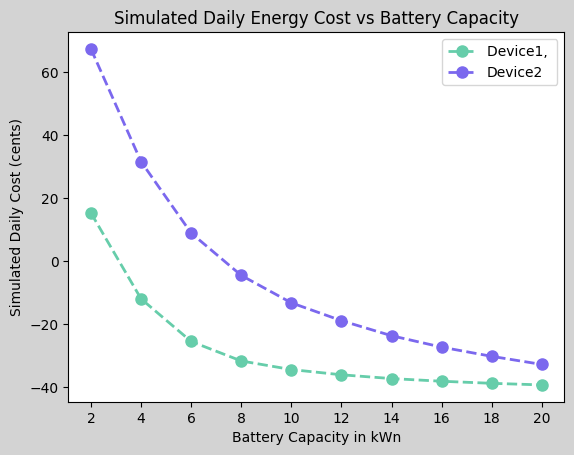

In [103]:
plt.figure(facecolor='lightgrey')
plt.plot(x1, y11, color='mediumaquamarine', marker='o', linestyle='dashed',linewidth=2, markersize=8)
plt.plot(x1, y22, color='mediumslateblue', marker='o', linestyle='dashed',linewidth=2, markersize=8)
plt.title('Simulated Daily Energy Cost vs Battery Capacity')
plt.ylabel("Simulated Daily Cost (cents)")
plt.xlabel("Battery Capacity in kWn")
plt.xticks(x1, x1)
plt.legend(['Device1, ', 'Device2'])

In [89]:
d1_len = len(complete_df[complete_df['DeviceID'] == device_list[0]])
d2_len = len(complete_df[complete_df['DeviceID'] == device_list[1]])